# What you will Learn
NLP is one of the most important areas of data science. This notebook focuses on the detection of `Fake News`. Most people tend to use deep learning approaches based on word embeddings, word sequences and other elaborate methods to detect them. In this notebook you will learn, that you can already achieve extremely good results by focusing on easily extracted features. Even though these methods are far from perfect, they are easy to perform and they allow us to get some valuable insights into the structure of Fake News.

<div class="alert alert-danger" role="alert">
    <h3>This notebook is work in progress. Feel free to <span style="color:red">comment</span> if you have any suggestions   |   motivate me with an <span style="color:red">upvote</span> if you like this project.</h3>
</div>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from wordcloud import STOPWORDS
import nltk
import string

In [ ]:
import pandas as pd
import io
from google.colab import files

# Get an overview of both CSVs and merge them together!
The data is provided in two separated csv files. One file contains real articles, the other file contains fake news. Let's get an idea of both files.

In [ ]:
url = 'https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv'

In [ ]:
data = pd.read_csv(url)

In [ ]:
data.head()

id  ... label
0   8476  ...  FAKE
1  10294  ...  FAKE
2   3608  ...  REAL
3  10142  ...  FAKE
4    875  ...  REAL

[5 rows x 4 columns]

In [ ]:
import nltk

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Let's take a look at Real News

In [ ]:
data

id  ... label
0      8476  ...  FAKE
1     10294  ...  FAKE
2      3608  ...  REAL
3     10142  ...  FAKE
4       875  ...  REAL
...     ...  ...   ...
6330   4490  ...  REAL
6331   8062  ...  FAKE
6332   8622  ...  FAKE
6333   4021  ...  REAL
6334   4330  ...  REAL

[6335 rows x 4 columns]

are there any missing values in `News.csv`?

In [ ]:
data.isna().sum()

id       0
title    0
text     0
label    0
dtype: int64

not a single column contains missing values!

Which `subjects` are contained in this file?

In [ ]:
# don't forget to shuffle them. 
# Otherwise all news are on top and all fakes are on the bottom
data = data.sample(frac=1)

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

For this notebook, I will ignore the `dates` and `subjects`(because they are disjoint). I will probably take a look at them in a later project. Let's drop them for now.

In [ ]:
data.duplicated().sum()

0

In [ ]:
data.head()

id  ... label
2386   7954  ...  FAKE
3301   1762  ...  REAL
4853   8672  ...  FAKE
2040  10524  ...  FAKE
2680   9715  ...  FAKE

[5 rows x 4 columns]

Are there any duplicates in the data? If yes, we would have to remove them

In [ ]:
data = data.drop(['id'], axis=1)


# ***Replace label with numeric values*** **bold text**

In [ ]:
data = data.replace(to_replace ="FAKE",
                 value =1)



In [ ]:
data = data.replace(to_replace ="REAL",
                 value =0)


Before taking a closer look at the data, perform a `train_test_split` to evade **Data Snooping**!

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)
X_train = train.drop('label', axis=1)
y_train = train['label']
X_test = test.drop('label', axis=1)
y_test = test['label']

In [ ]:
X_train.head()

title                                               text
3346        Donald Trump's year of tweeting dangerously  Killing Obama administration rules, dismantlin...
6257  As Flint Suffers, Nestlé Plans Dramatic Expans...  By Lauren McCauley The state of Michigan has r...
2059  Report: Freddie Gray may have intentionally tr...  Freddie Gray, whose death triggered Monday’s r...
988   David Sweat shot, captured alive after New Yor...  Malone, New York (CNN) After a massive, more-t...
335   Poll finds Ben Carson knocks Donald Trump from...  For the first time in months, a national poll ...

how are Fake News distributed among the train and the test data?

In [ ]:
y_train.value_counts()

1    2537
0    2531
Name: label, dtype: int64

In [ ]:
y_test.value_counts()

0    640
1    627
Name: label, dtype: int64

# Inspect the Training data to get further insights
Therefore we have to split the Training set into News and Fake News

In [ ]:
train_news = X_train.loc[(y_train==0),:]
train_fake = X_train.loc[(y_train==1),:]

## Lexical Diversity of Fake News
Let's define a measure for lexical diversity to find out how many unique vocabs are used in Fake News articles.

Let's define the lexical diversity measure as $\frac{\text{number of unique words in one (target)category}}{\text{number of words in both (target)categories}}$

In [ ]:
# a very simple measure for lexical diversity
def lexical_diversity(data, other_data, feature):
    # ignoare capital letters
    column = data[feature].str.lower() 
    # create one text from the column
    text = ' '.join(column)
    # drop punctuation
    exclude = set(string.punctuation)
    words = ''.join(char for char in text if char not in exclude)
    # create a list of wordsw instead of one huge text
    words_splitted = words.split()
    
    # analogously
    other_column = other_data[feature].str.lower() 
    other_text = ' '.join(other_column)
    other_words = ''.join(char for char in other_text if char not in exclude)
    other_words_splitted = other_words.split()
    # lexical diversity measure
    return len(set(words_splitted)) / (len(words_splitted) + len(other_words_splitted))

print(f'Real News: {lexical_diversity(data=train_news, other_data=train_fake, feature="text")}')
print(f'Fake News: {lexical_diversity(data=train_fake, other_data=train_news, feature="text")}')

Real News: 0.015224722125819316
Fake News: 0.017866400485112344


Interestingly it seems like `Fake News` contain almost two times greater lexical diversity than real news. Their authors seem to have a wide vocabulary.

## Most frequently used words in Titles
is there a difference between the most frequently used words in the titles of Real News and Fake News? This question might already reveal the topics of the Fake News articles.

In [ ]:
stopwords = set(STOPWORDS)

def common_tokens_title(data, feature, name):
    column = data[feature].str.lower() 
    text = ' '.join(column)
    exclude = set(string.punctuation)
    words = ''.join(char for char in text if char not in exclude)
    words_splitted = words.split()
    words_stopped = [word for word in words_splitted if not word in stopwords]
    print(f'{name}:\n{pd.DataFrame(nltk.FreqDist(words_stopped).most_common(10))[0]}')
    
common_tokens_title(train_news, 'title', 'Most common descriptive words in Real News Titles')
print('\n')
common_tokens_title(train_fake, 'title', 'Most common descriptive words in Fake News Titles')

Most common descriptive words in Real News Titles:
0      trump
1    clinton
2        gop
3      obama
4     donald
5    hillary
6     debate
7       2016
8        new
9         us
Name: 0, dtype: object


Most common descriptive words in Fake News Titles:
0       trump
1     hillary
2     clinton
3          us
4           –
5    election
6         new
7        will
8       video
9      russia
Name: 0, dtype: object


It seems like most Fake News Articles in our Training data are about US Presidents and candidates for the latter. Besides `trump`, the real news seem to focus on more general political topics.

# Punctutation
Punctuation might provide some information for predictions. 

In [ ]:
import regex as re

# let's begin with a helper function to count punctuation
def count_punctuation(text):
    peri = re.subn(r"\.", '', text)[1]
    comm = re.subn(r"\,", '', text)[1]
    ques = re.subn(r"\?", '', text)[1]
    excl = re.subn(r"\!", '', text)[1]
    return [peri,comm, ques, excl]
    
count_punctuation('...alph!a.beta.gamma...??')

[8, 0, 2, 1]

In [ ]:
# count the usage of puntuations per row in a specified feature (title and text)
# and store the data in a dataframe
def create_punctuation_df(dataset, feature):
    return dataset.apply(lambda row: pd.Series({'peri_' + feature:count_punctuation(row[feature])[0], 
                                                       'comm_' + feature:count_punctuation(row[feature])[1],
                                                      'ques_' + feature:count_punctuation(row[feature])[2],
                                                      'excl_' + feature:count_punctuation(row[feature])[3]}), axis=1)

punctuation_train_title = create_punctuation_df(train, 'title')
punctuation_test_title = create_punctuation_df(test, 'title')
punctuation_train_text = create_punctuation_df(train, 'text')
punctuation_test_text = create_punctuation_df(test, 'text')
punctuation_train_text 

peri_text  comm_text  ques_text  excl_text
3346          1          1          0          0
6257          3          1          0          0
2059         26         29          0          0
988          44         50          0          1
335          14         14          0          0
...         ...        ...        ...        ...
534          30         43          1          0
6163         28         36          1          0
5911          3          0          0          0
2806         30         33          0          0
5125          6         10          2          0

[5068 rows x 4 columns]

# Text Length

In [ ]:
# count the text length per row for both features (title and text)
# and store the information in a dataframe
def create_len_df(dataset):
    return dataset.apply(lambda row: pd.Series({'length_title':len(row['title']),
                                               'length_text':len(row['text'])}), axis=1)

len_train = create_len_df(train)
len_test = create_len_df(test)

len_train

length_title  length_text
3346            43          117
6257            84          201
2059            78         2841
988             55         4559
335             66         1771
...            ...          ...
534            106         3928
6163            93         3342
5911            34          240
2806            53         4256
5125           135         1630

[5068 rows x 2 columns]

## Number of Words in the Title
Let's create a feature which counts the number of words in the Title. In my **Digital Markeeting Courses** I learned, that titles are extremely important when it comes to grabbing Attention. A rule of thumbs tells us that titles should have about 5 words.

In [ ]:
def create_num_words_df(dataset):
    return dataset.apply(lambda row: pd.Series({'num_words_title':len(row['title'].split())}), axis=1)

num_words_train = create_num_words_df(train)
num_words_test = create_num_words_df(test)

num_words_train

num_words_title
3346                6
6257               12
2059               13
988                 9
335                11
...               ...
534                15
6163               14
5911                8
2806               10
5125               24

[5068 rows x 1 columns]

## Lenght of Title Relative to the Length of the Article + Title
One could assume that some attention grabbing Fake News have a long title and very short texts. Is that true?

In [ ]:
def create_title_ratio_df(dataset):
    return dataset.apply(lambda row: pd.Series({'title_ratio':len(row['title'])/(len(row['title']) + len(row['text']))}), axis=1)

title_ratio_train = create_title_ratio_df(train)
title_ratio_test = create_title_ratio_df(test)

title_ratio_train

title_ratio
3346     0.268750
6257     0.294737
2059     0.026721
988      0.011920
335      0.035928
...           ...
534      0.026277
6163     0.027074
5911     0.124088
2806     0.012300
5125     0.076487

[5068 rows x 1 columns]

## Concatenate the new Datasets

In [ ]:
X_train_punct_len = pd.concat([punctuation_train_title, 
                               punctuation_train_text, 
                               len_train, 
                               num_words_train, 
                               title_ratio_train], 
                              axis=1)

X_test_punct_len = pd.concat([punctuation_test_title, 
                              punctuation_test_text, 
                              len_test, 
                              num_words_test, 
                              title_ratio_test], 
                             axis=1)

X_train_punct_len

peri_title  comm_title  ...  num_words_title  title_ratio
3346           0           0  ...                6     0.268750
6257           0           1  ...               12     0.294737
2059           0           0  ...               13     0.026721
988            0           1  ...                9     0.011920
335            0           0  ...               11     0.035928
...          ...         ...  ...              ...          ...
534            0           1  ...               15     0.026277
6163           1           0  ...               14     0.027074
5911           0           0  ...                8     0.124088
2806           0           0  ...               10     0.012300
5125           0           0  ...               24     0.076487

[5068 rows x 12 columns]

## **Let's clean the data and add sentiment features**




In [ ]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.corpus import wordnet
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

# Data Cleaning

In [ ]:
X_sentiment_train = X_train
X_sentiment_test = X_test

In [ ]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
        # join all
    text = " ".join(text)
    return(text)

# clean text data
X_sentiment_train['text'] = X_sentiment_train['text'].apply(lambda x: clean_text(x))

In [ ]:
X_sentiment_train['text']

3346    kill obama administration rule dismantle obama...
6257    lauren mccauley state michigan reportedly issu...
2059    freddie gray whose death trigger monday’s riot...
988     malone new york cnn massive more-than-three-we...
335     first time month national poll show donald tru...
                              ...                        
534     new video investigation release monday james o...
6163    post eddie sky-high potency may scare away cry...
5911    black member elite page relate thread godlike ...
2806    president obama double friday push shutter gua...
5125    new report find voter idea outrage suppose any...
Name: text, Length: 5068, dtype: object

In [ ]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = X_sentiment_train['text'].apply(lambda x: sid.polarity_scores(x))
sent_scores_df = pd.DataFrame(list(sentiment_scores))


In [ ]:
sent_scores_df.head()

neg    neu    pos  compound
0  0.299  0.701  0.000   -0.6908
1  0.000  0.853  0.147    0.4767
2  0.227  0.718  0.054   -0.9953
3  0.131  0.766  0.103   -0.9648
4  0.038  0.850  0.112    0.8957

In [ ]:
sent_scores_df

neg    neu    pos  compound
0     0.299  0.701  0.000   -0.6908
1     0.000  0.853  0.147    0.4767
2     0.227  0.718  0.054   -0.9953
3     0.131  0.766  0.103   -0.9648
4     0.038  0.850  0.112    0.8957
...     ...    ...    ...       ...
5063  0.116  0.767  0.117   -0.5106
5064  0.102  0.731  0.167    0.9764
5065  0.000  1.000  0.000    0.0000
5066  0.117  0.753  0.130    0.5267
5067  0.190  0.652  0.158   -0.7204

[5068 rows x 4 columns]

In [ ]:
sent_scores_df.index = X_train_punct_len.index

In [ ]:
X_train_punct_len['negative'] = sent_scores_df['neg']
X_train_punct_len['positive'] = sent_scores_df['pos']
X_train_punct_len['neutral'] = sent_scores_df['neu']

# Investigate the Engineered Features

In [ ]:
X_train_punct_len.head()

peri_title  comm_title  ques_title  ...  negative  positive  neutral
3346           0           0           0  ...     0.299     0.000    0.701
6257           0           1           0  ...     0.000     0.147    0.853
2059           0           0           0  ...     0.227     0.054    0.718
988            0           1           0  ...     0.131     0.103    0.766
335            0           0           0  ...     0.038     0.112    0.850

[5 rows x 15 columns]

* Many Titles don't contain any form of `punctuation`!

* Some texts contain suspiciously small amounts of characters. At least one of them contains only 1 chars

Let's remove some extreme outliers!

In [ ]:
from scipy import stats
X_train_punct_len_zscore = X_train_punct_len.apply(stats.zscore, axis=0)
mask_outliers = np.logical_not(((X_train_punct_len_zscore>5).any(axis=1)).values + ((X_train_punct_len_zscore<-5).any(axis=1)).values)
X_train_punct_len = X_train_punct_len.loc[mask_outliers,:]
y_train = y_train[X_train_punct_len.index]

How does our data look like now?

In [ ]:
X_train_punct_len.describe()

peri_title   comm_title  ...     positive      neutral
count  4884.000000  4884.000000  ...  4884.000000  4884.000000
mean      0.106061     0.215397  ...     0.140641     0.737951
std       0.397375     0.465347  ...     0.063930     0.085262
min       0.000000     0.000000  ...     0.000000     0.435000
25%       0.000000     0.000000  ...     0.102000     0.685000
50%       0.000000     0.000000  ...     0.137000     0.736000
75%       0.000000     0.000000  ...     0.178000     0.788000
max       2.000000     2.000000  ...     0.466000     1.000000

[8 rows x 15 columns]

## How do they interact with each other?

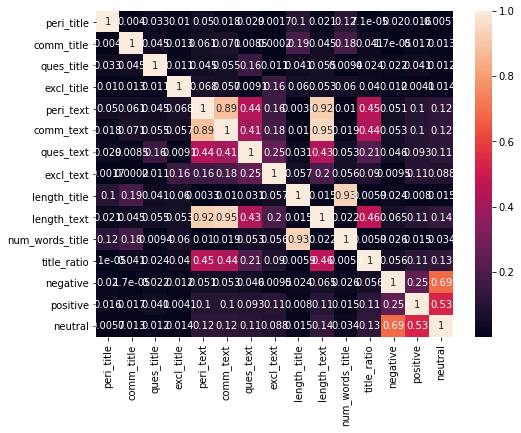

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(np.abs(X_train_punct_len.corr()), annot=True)
plt.savefig('correlation')
plt.show()

* huge correlation between `peri_text` and `length_text`

* huge correlation between `comm_text` and `length_text`

* huge correlation between `comm_text` and `peri_text`

* huge correlation between `peri_test` and `num_words_text`

...and so on

We have to find out how they interact with the target to determine what to do with them.

## How do they Interact with the Target?

In [ ]:
pd.concat([X_train_punct_len, y_train], axis=1).groupby('label').mean()

peri_title  comm_title  ques_title  ...  negative  positive   neutral
label                                      ...                              
0        0.117671    0.251004    0.089157  ...  0.118516  0.141912  0.739566
1        0.093985    0.178363    0.073935  ...  0.124431  0.139320  0.736271

[2 rows x 15 columns]

**Main Findings:**
* Titles of Fake News contain ~4 times less `periods`

* Titles of Fake News contain ~10 times more `question marks`

* Titles of Fake News contain ~130 times more `exclamation marks` **(wow!)**

* Texts of Fake News contain ~10 times more `question marks` 

* Texts of Fake News contain ~10 times more `exclamation marks`

* Titles of Fake News are 50% `longer`. The number of words seems to reflect that fact as well. -> The length of words in the titles of Fake News and real News don't seem to vary a lot.

* $\frac{len(title)}{len(title) + len(text)}$ is ~40% longer in Fake News

* Let's ignore the high correlations we found above. A more elaborate approach would be to eliminate correlating features by dropping them or using dimensionality reduction like PCA

# A Simple Model based on Punctuation and Text Length
Let's use a default RandomForest for our classification!

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
preds = cross_val_predict(rf, X_train_punct_len, y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
acc = accuracy_score(y_true=y_train, y_pred=preds)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.7311872909698997
acc: 0.736637313127176


These are already pretty nice results on train! What are the most `important features`?

In [ ]:
rf.fit(X_train_punct_len, y_train)
pd.Series(rf.feature_importances_, 
          index=X_train_punct_len.columns).sort_values(ascending=False)

peri_text          0.133536
length_text        0.129905
title_ratio        0.120736
comm_text          0.095220
length_title       0.090309
negative           0.084244
positive           0.083800
neutral            0.081833
num_words_title    0.061811
ques_text          0.042918
excl_text          0.039500
comm_title         0.014719
peri_title         0.009665
ques_title         0.006407
excl_title         0.005397
dtype: float64

Interestingly, the length of the title is way more important than e.g. `excl_title`, even though the relation between the target and `excl_title` is way stronger. This is most likely the case because only a few titles contain exclamation marks.

## Finetune the model

In [ ]:
from sklearn.model_selection import GridSearchCV
params= {'n_estimators':[200, 300],
        'criterion':['gini', 'entropy'],
        'max_depth':[5, None],
        'max_features':[2,5]}
gscv = GridSearchCV(rf, params)
gscv.fit(X_train_punct_len, y_train)
gscv.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 2,
 'n_estimators': 300}

In [ ]:
rf_tuned = RandomForestClassifier(criterion='entropy', max_depth=None, max_features=2, n_estimators=200, random_state=42)
preds = cross_val_predict(rf_tuned, X_train_punct_len, y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
acc = accuracy_score(y_true=y_train, y_pred=preds)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.7365534697321241
acc: 0.7442146221585091


In [ ]:
rf_tuned.fit(X_train_punct_len, y_train)
pd.Series(rf_tuned.feature_importances_, 
          index=X_train_punct_len.columns).sort_values(ascending=False)

length_text        0.123547
peri_text          0.115648
title_ratio        0.114766
comm_text          0.099925
length_title       0.092310
negative           0.091638
neutral            0.087135
positive           0.087016
num_words_title    0.066934
ques_text          0.043973
excl_text          0.036169
comm_title         0.015585
peri_title         0.010413
ques_title         0.007554
excl_title         0.007388
dtype: float64

## Final Prediction on Test

In [ ]:
X_sentiment_test['text'] = X_sentiment_test['text'].apply(lambda x: clean_text(x))

In [ ]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = X_sentiment_test['text'].apply(lambda x: sid.polarity_scores(x))
sent_scores_test = pd.DataFrame(list(sentiment_scores))


In [ ]:
sent_scores_test.head()

neg    neu    pos  compound
0  0.034  0.758  0.208    0.9990
1  0.140  0.665  0.195    0.9608
2  0.115  0.794  0.091   -0.9022
3  0.151  0.689  0.160    0.0433
4  0.112  0.694  0.194    0.9623

In [ ]:
sent_scores_test.index = X_test_punct_len.index

In [ ]:
X_test_punct_len['negative'] = sent_scores_test['neg']
X_test_punct_len['positive'] = sent_scores_test['pos']
X_test_punct_len['neutral'] = sent_scores_test['neu']

In [ ]:
preds_test = rf_tuned.predict(X_test_punct_len) 
f1 = f1_score(y_true=y_test, y_pred=preds_test)
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.726672171758877
acc: 0.7387529597474349


`f1-score` of about 93%! Our model is already very powerful, even though it solely focuses on punctuation and text length. Moreover, it performs even better than on train!

# How well can we predict on subsets of the Features?

In [ ]:
forest = RandomForestClassifier(random_state=42)

best_column = 'all'
best_score = 0
for column in X_train_punct_len.columns:
    forest.fit(X_train_punct_len[column].values.reshape((-1,1)), y_train)
    preds = cross_val_predict(forest, X_train_punct_len[column].values.reshape((-1,1)), y_train, cv=5)
    f1 = f1_score(y_true=y_train, y_pred=preds)
    
    if(f1>best_score):
        best_score = f1
        best_column = column

print(f'A default RandomForest already obtains an f1-score of {f1} on validation data when trained solely on the column {column}')

A default RandomForest already obtains an f1-score of 0.38525014949172814 on validation data when trained solely on the column neutral


In [ ]:
forest = RandomForestClassifier(random_state=42)
punctuation = ['peri_title', 'comm_title', 'ques_title', 'excl_title', 'peri_text', 'comm_text', 'ques_text', 'excl_text']
lenght = ['length_title', 'length_text','num_words_title', 'title_ratio']


forest.fit(X_train_punct_len[punctuation], y_train)
preds = cross_val_predict(forest, X_train_punct_len[punctuation], y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
print(f'A default RandomForest already obtains an f1-score of {f1} when trained solely on punctuation-based Features')
print('The Feature Inportances in that approach are:')
print(pd.Series(forest.feature_importances_, 
          index=punctuation).sort_values(ascending=False))

forest.fit(X_train_punct_len[lenght], y_train)
preds = cross_val_predict(forest, X_train_punct_len[lenght], y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
print(f'A default RandomForest already obtains an f1-score of {f1} when trained solely on length-based Features')
print('The Feature Importances in that approach are:')
print(pd.Series(forest.feature_importances_, 
          index=lenght).sort_values(ascending=False))

A default RandomForest already obtains an f1-score of 0.7467359208794336 when trained solely on punctuation-based Features
The Feature Inportances in that approach are:
ques_text     0.280368
comm_text     0.209380
peri_text     0.205038
excl_text     0.129412
peri_title    0.087740
excl_title    0.074116
comm_title    0.013946
ques_title    0.000000
dtype: float64
A default RandomForest already obtains an f1-score of 0.8499982896042144 when trained solely on length-based Features
The Feature Importances in that approach are:
length_title       0.404039
title_ratio        0.208556
length_text        0.197260
num_words_title    0.190145
dtype: float64


As we saw, even some basic feature engineering might reveal powerful features for our machine learning models. I am pretty sure that adding `Word Embeddings` will improve the performance by a lot.

Thank you for reading this notebook!